In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from matplotlib import rcParams
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
rcParams['figure.figsize'] = (12, 8)
rcParams['font.size'] = 12

# Read JSON data
json_path = sorted(Path('.').glob('gaussian_eval_*.json'))[0]

MODEL PATH: teacher_blur_training/dinov3-vith16plus-pretrain-lvd1689m_blur00/best_teacher_blur_model.pth
BLUR MODE: both
BATCH SIZE: 256

DATASET OVERVIEW:
----------------------------------------------------------------------------------------------------
    dataset blur_mode  accuracy  precision    recall  f1_score  total_samples  time_seconds
0    reddit   no_blur  0.878000   0.812569  0.982667  0.889559           1500     32.426460
1    reddit    global  0.744000   0.679412  0.924000  0.783051           1500     34.878775
2  facebook   no_blur  0.837500   0.767327  0.968750  0.856354            320      7.148159
3  facebook    global  0.721875   0.660633  0.912500  0.766404            320      8.859738
4   twitter   no_blur  0.904988   0.883495  0.985560  0.931741            421     11.772109
5   twitter    global  0.807601   0.816129  0.913357  0.862010            421     15.161110
---------------------------------------------------------------------------------------------------

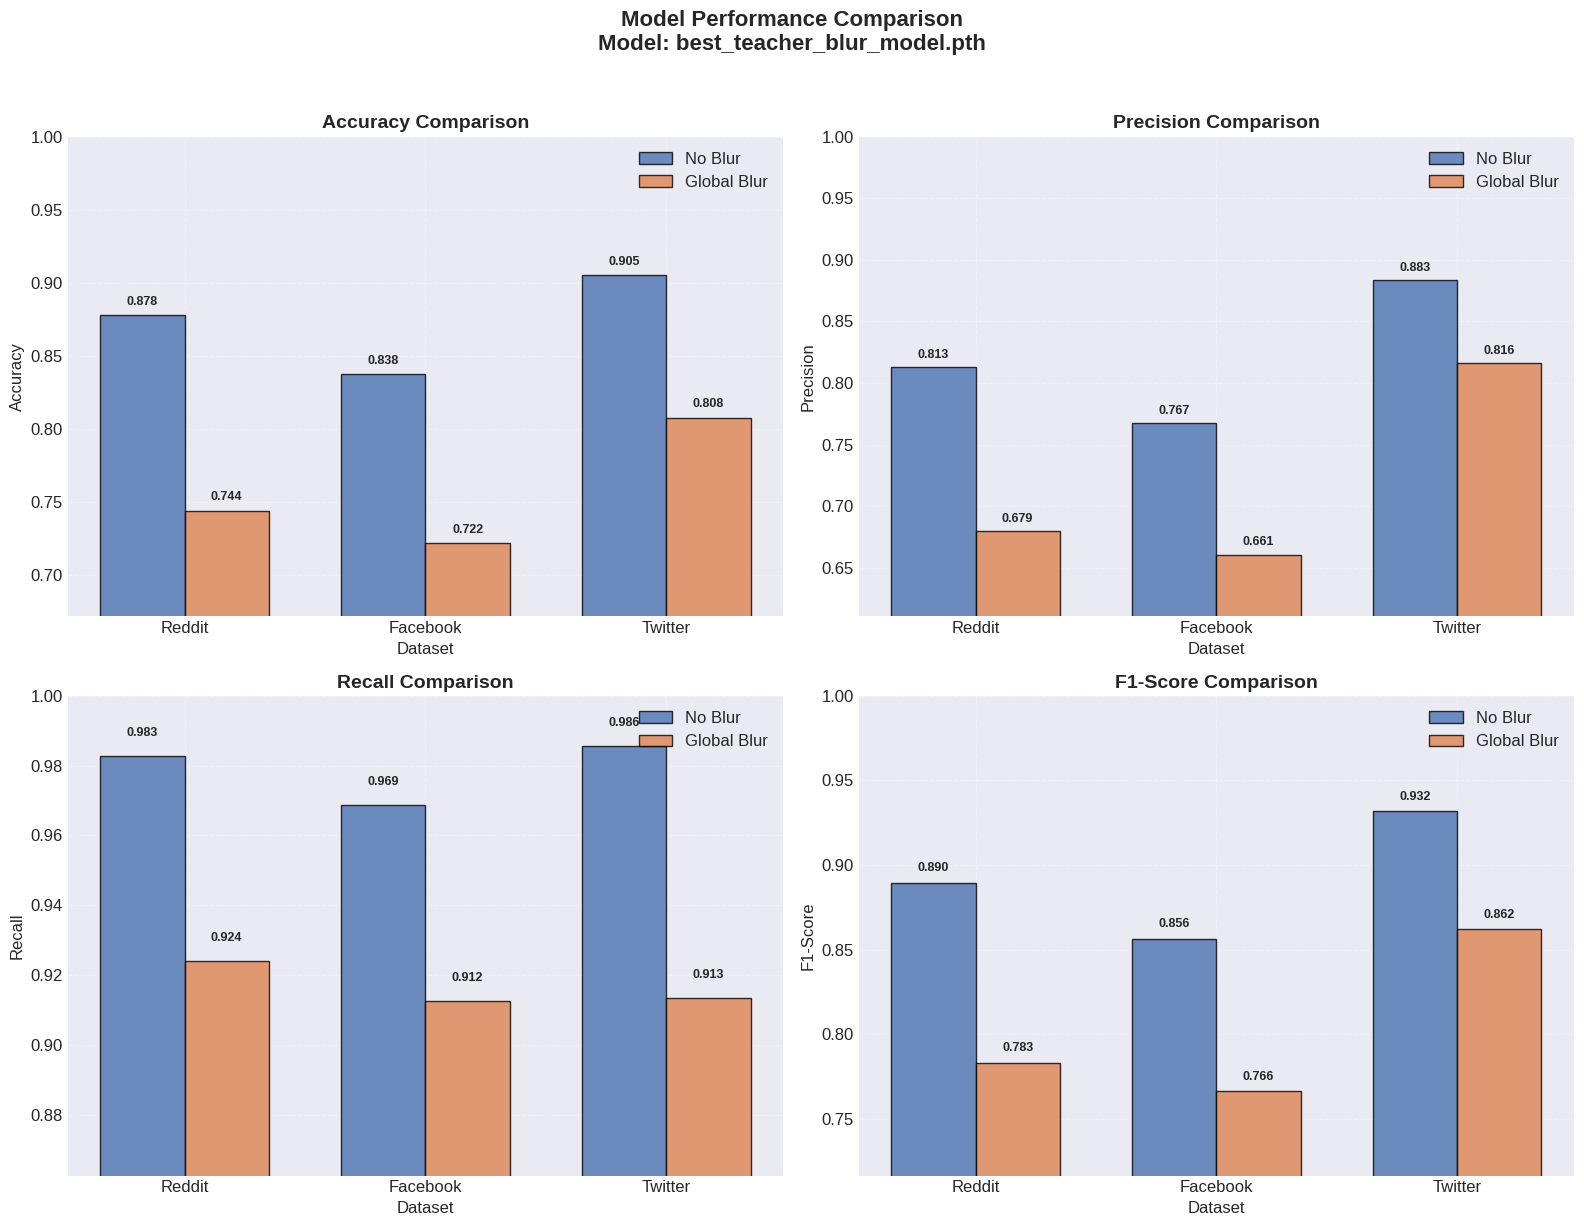

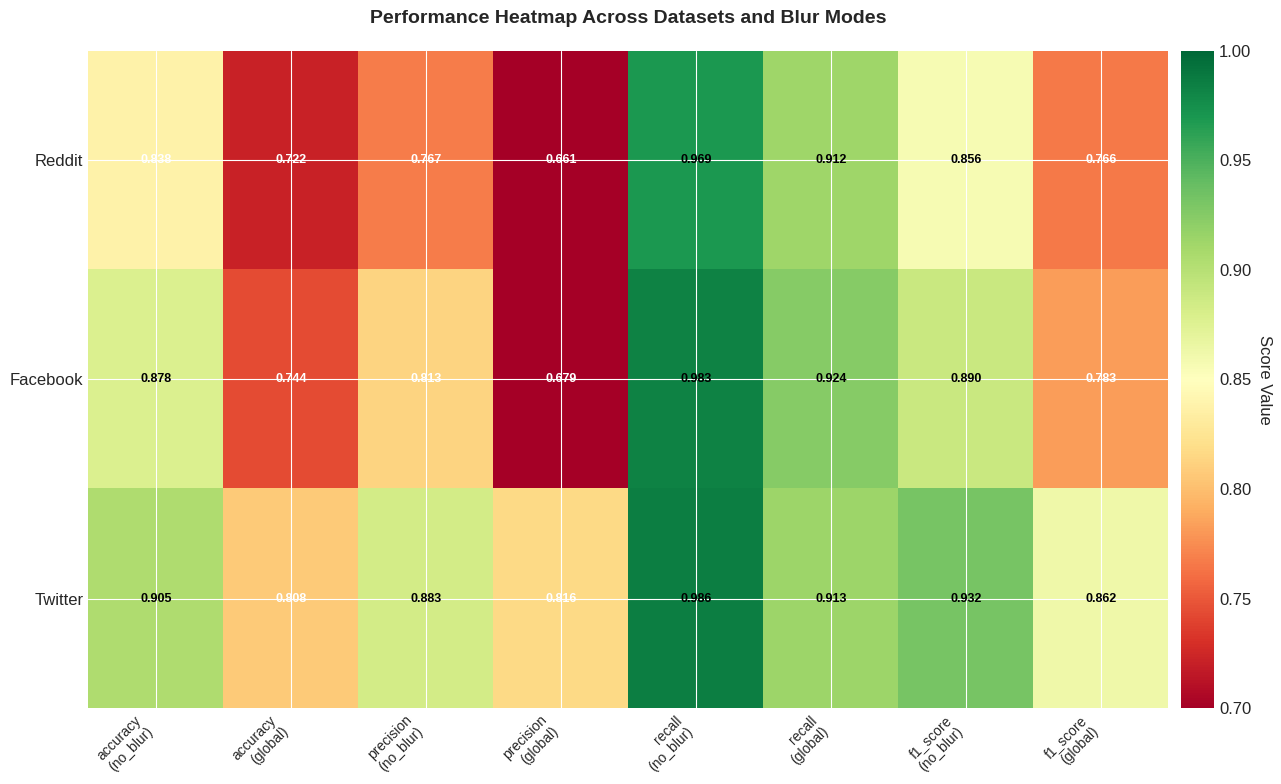

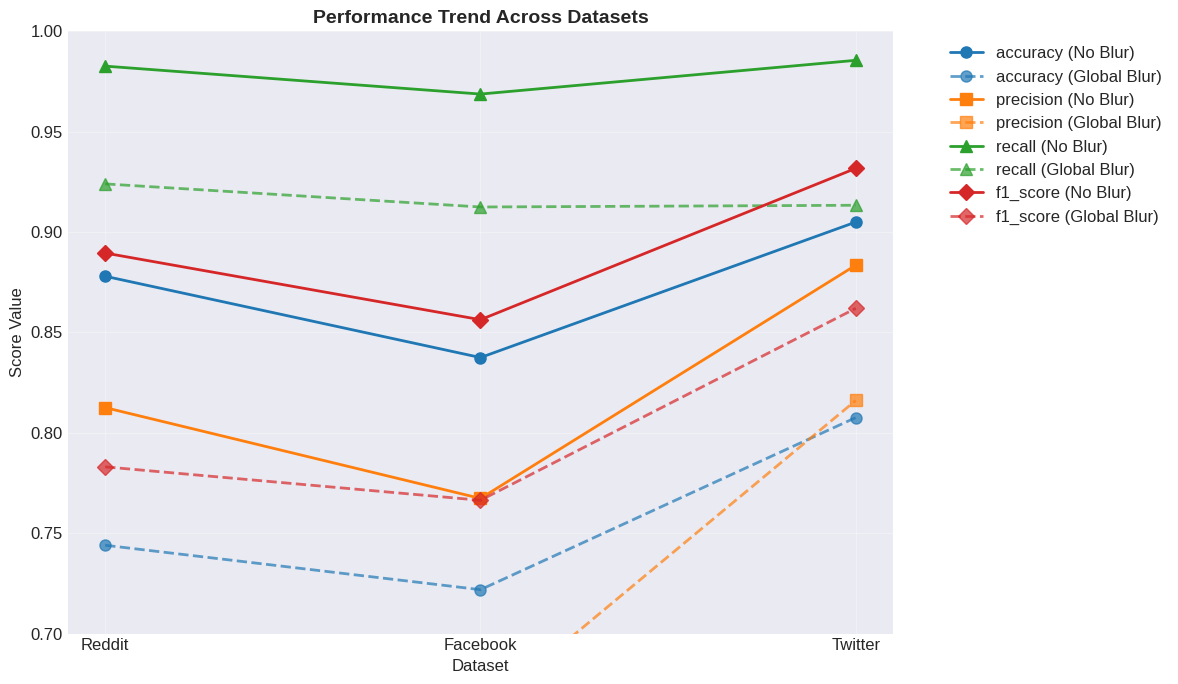

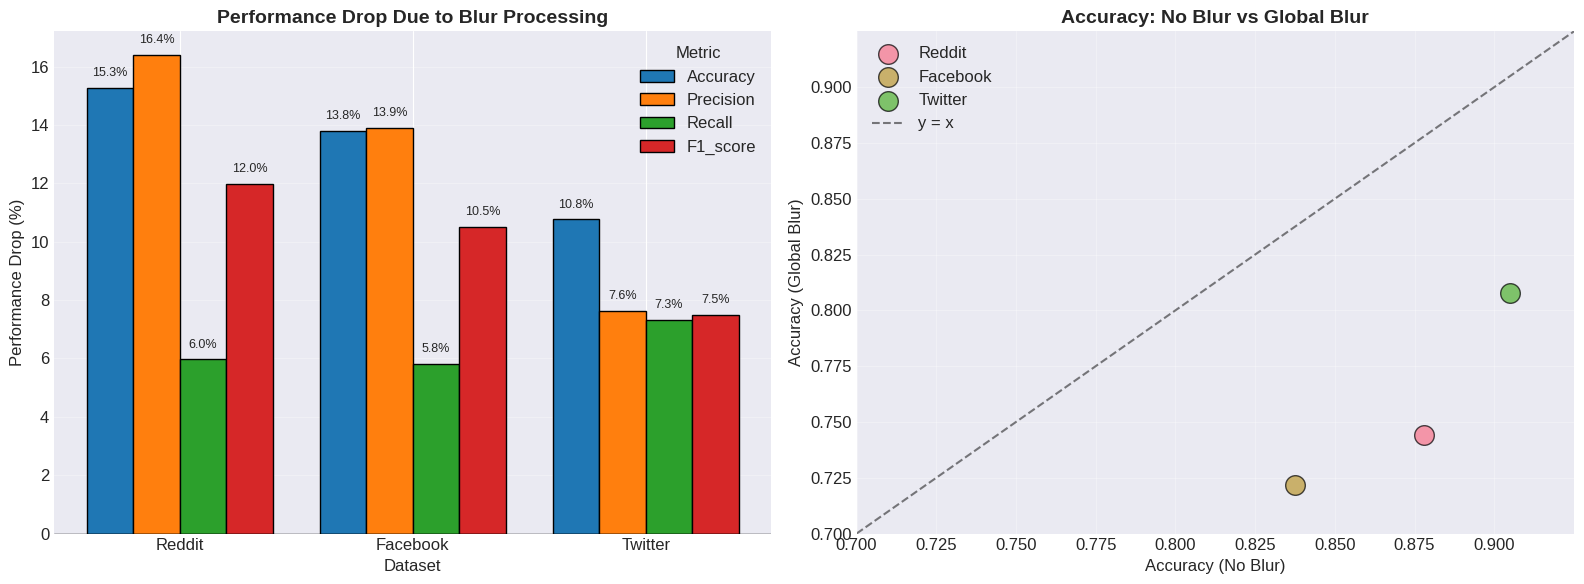


Generating Interactive Charts...



PERFORMANCE SUMMARY STATISTICS
 Dataset Blur Mode  Samples Accuracy Precision Recall F1-Score Time (s)
  REDDIT   No Blur     1500   0.8780    0.8126 0.9827   0.8896    32.43
  REDDIT    Global     1500   0.7440    0.6794 0.9240   0.7831    34.88
FACEBOOK   No Blur      320   0.8375    0.7673 0.9688   0.8564     7.15
FACEBOOK    Global      320   0.7219    0.6606 0.9125   0.7664     8.86
 TWITTER   No Blur      421   0.9050    0.8835 0.9856   0.9317    11.77
 TWITTER    Global      421   0.8076    0.8161 0.9134   0.8620    15.16

PERFORMANCE ANALYSIS

BEST PERFORMANCE - NO BLUR:
  Dataset: TWITTER
  Accuracy: 0.9050
  F1-Score: 0.9317
  Precision: 0.8835
  Recall: 0.9856

BEST PERFORMANCE - GLOBAL BLUR:
  Dataset: TWITTER
  Accuracy: 0.8076
  F1-Score: 0.8620
  Precision: 0.8161
  Recall: 0.9134

AVERAGE PERFORMANCE:
  No Blur - Accuracy: 0.8735, F1: 0.8926
  Global Blur - Accuracy: 0.7578, F1: 0.8038

OVERALL PERFORMANCE DROP DUE TO BLUR: 10.51%


In [2]:


with open(json_path, 'r') as f:
    data = json.load(f)

# Extract model information
model_path = data['config']['model_path']
blur_config = data['config']['blur_mode']
batch_size = data['config']['batch_size']

print("="*100)
print(f"MODEL PATH: {model_path}")
print(f"BLUR MODE: {blur_config}")
print(f"BATCH SIZE: {batch_size}")
print("="*100)

# Create DataFrame from results
rows = []
for dataset, modes in data['results'].items():
    for mode, metrics in modes.items():
        rows.append({
            'dataset': dataset,
            'blur_mode': metrics['blur_mode'],
            'accuracy': metrics['accuracy'],
            'precision': metrics['precision'],
            'recall': metrics['recall'],
            'f1_score': metrics['f1_score'],
            'total_samples': metrics['total_samples'],
            'time_seconds': metrics['time_seconds']
        })

df = pd.DataFrame(rows)

# Print dataset overview
print("\nDATASET OVERVIEW:")
print("-"*100)
print(df.to_string())
print("-"*100)

# 1. Bar Chart Comparison - All Metrics
fig1, axes1 = plt.subplots(2, 2, figsize=(16, 12))
fig1.suptitle(f'Model Performance Comparison\nModel: {model_path.split("/")[-1]}', 
              fontsize=16, fontweight='bold', y=1.02)

metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score']
metric_titles = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for idx, (metric, title) in enumerate(zip(metrics_to_plot, metric_titles)):
    ax = axes1[idx//2, idx%2]
    
    # Prepare data for plotting
    x = np.arange(len(df['dataset'].unique()))
    width = 0.35
    
    no_blur_vals = []
    global_vals = []
    
    for dataset in df['dataset'].unique():
        dataset_df = df[df['dataset'] == dataset]
        no_blur_val = dataset_df[dataset_df['blur_mode'] == 'no_blur'][metric].values[0]
        global_val = dataset_df[dataset_df['blur_mode'] == 'global'][metric].values[0]
        no_blur_vals.append(no_blur_val)
        global_vals.append(global_val)
    
    bars1 = ax.bar(x - width/2, no_blur_vals, width, label='No Blur', 
                   color='#4C72B0', alpha=0.8, edgecolor='black')
    bars2 = ax.bar(x + width/2, global_vals, width, label='Global Blur', 
                   color='#DD8452', alpha=0.8, edgecolor='black')
    
    ax.set_xlabel('Dataset', fontsize=12)
    ax.set_ylabel(title, fontsize=12)
    ax.set_title(f'{title} Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([d.capitalize() for d in df['dataset'].unique()])
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9,
                   fontweight='bold')
    
    # Set y-axis limit for better visualization
    ax.set_ylim([min(min(no_blur_vals), min(global_vals)) - 0.05, 1.0])

plt.tight_layout()
plt.show()

# 2. Heatmap Visualization
fig2, ax2 = plt.subplots(figsize=(14, 8))

# Create pivot table for heatmap
pivot_df = df.pivot(index='dataset', columns='blur_mode', 
                    values=['accuracy', 'precision', 'recall', 'f1_score'])

# Prepare heatmap data
heatmap_data = []
metric_labels = []
for metric in ['accuracy', 'precision', 'recall', 'f1_score']:
    for blur in ['no_blur', 'global']:
        heatmap_data.append(pivot_df[metric][blur].values)
        metric_labels.append(f'{metric}\n({blur})')

heatmap_matrix = np.array(heatmap_data).T

# Create heatmap
im = ax2.imshow(heatmap_matrix, cmap='RdYlGn', aspect='auto', vmin=0.7, vmax=1.0)

# Add colorbar
cbar = ax2.figure.colorbar(im, ax=ax2, pad=0.01)
cbar.ax.set_ylabel('Score Value', rotation=-90, va="bottom", fontsize=12)

# Set labels
ax2.set_xticks(np.arange(len(metric_labels)))
ax2.set_yticks(np.arange(len(df['dataset'].unique())))
ax2.set_xticklabels(metric_labels, rotation=45, ha='right', fontsize=10)
ax2.set_yticklabels([d.capitalize() for d in df['dataset'].unique()], fontsize=12)

# Add text annotations
for i in range(len(df['dataset'].unique())):
    for j in range(len(metric_labels)):
        text = ax2.text(j, i, f'{heatmap_matrix[i, j]:.3f}',
                       ha="center", va="center", 
                       color="white" if heatmap_matrix[i, j] < 0.85 else "black",
                       fontsize=9, fontweight='bold')

ax2.set_title("Performance Heatmap Across Datasets and Blur Modes", 
              fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# 3. Line Chart - Performance Trend
fig3, ax3 = plt.subplots(figsize=(12, 7))

# Prepare data for line chart
datasets = df['dataset'].unique()
x = np.arange(len(datasets))

# Plot each metric
metrics_line = ['accuracy', 'precision', 'recall', 'f1_score']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
markers = ['o', 's', '^', 'D']

for idx, metric in enumerate(metrics_line):
    no_blur_vals = []
    global_vals = []
    
    for dataset in datasets:
        dataset_df = df[df['dataset'] == dataset]
        no_blur_vals.append(dataset_df[dataset_df['blur_mode'] == 'no_blur'][metric].values[0])
        global_vals.append(dataset_df[dataset_df['blur_mode'] == 'global'][metric].values[0])
    
    # Plot no blur
    ax3.plot(x, no_blur_vals, label=f'{metric} (No Blur)', 
             color=colors[idx], marker=markers[idx], linewidth=2, markersize=8)
    # Plot global blur
    ax3.plot(x, global_vals, label=f'{metric} (Global Blur)', 
             color=colors[idx], marker=markers[idx], linestyle='--', 
             linewidth=2, markersize=8, alpha=0.7)

ax3.set_xlabel('Dataset', fontsize=12)
ax3.set_ylabel('Score Value', fontsize=12)
ax3.set_title('Performance Trend Across Datasets', fontsize=14, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels([d.capitalize() for d in datasets])
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.grid(True, alpha=0.3)
ax3.set_ylim([0.7, 1.0])

plt.tight_layout()
plt.show()

# 4. Performance Drop Analysis
fig4, (ax4_1, ax4_2) = plt.subplots(1, 2, figsize=(16, 6))

# Calculate performance drop
performance_drop_data = []
for dataset in datasets:
    no_blur_df = df[(df['dataset'] == dataset) & (df['blur_mode'] == 'no_blur')].iloc[0]
    global_df = df[(df['dataset'] == dataset) & (df['blur_mode'] == 'global')].iloc[0]
    
    drop_values = {}
    for metric in ['accuracy', 'precision', 'recall', 'f1_score']:
        drop_pct = (no_blur_df[metric] - global_df[metric]) / no_blur_df[metric] * 100
        drop_values[metric] = drop_pct
        performance_drop_data.append({
            'dataset': dataset,
            'metric': metric,
            'drop_pct': drop_pct,
            'no_blur': no_blur_df[metric],
            'global': global_df[metric]
        })

drop_df = pd.DataFrame(performance_drop_data)

# Bar chart for performance drop
x = np.arange(len(datasets))
width = 0.2
metric_colors = {'accuracy': '#1f77b4', 'precision': '#ff7f0e', 
                 'recall': '#2ca02c', 'f1_score': '#d62728'}

for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1_score']):
    metric_data = drop_df[drop_df['metric'] == metric]
    values = metric_data['drop_pct'].values
    bars = ax4_1.bar(x + i*width - 1.5*width, values, width, 
                     label=metric.capitalize(), 
                     color=metric_colors[metric], 
                     edgecolor='black')
    
    for bar in bars:
        height = bar.get_height()
        ax4_1.text(bar.get_x() + bar.get_width()/2., height + 0.3,
                  f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

ax4_1.set_xlabel('Dataset', fontsize=12)
ax4_1.set_ylabel('Performance Drop (%)', fontsize=12)
ax4_1.set_title('Performance Drop Due to Blur Processing', fontsize=14, fontweight='bold')
ax4_1.set_xticks(x)
ax4_1.set_xticklabels([d.capitalize() for d in datasets])
ax4_1.legend(title='Metric')
ax4_1.grid(True, alpha=0.3, axis='y')
ax4_1.axhline(y=0, color='black', linestyle='-', linewidth=1)

# Scatter plot: No Blur vs Global Blur
for dataset in datasets:
    dataset_df = df[df['dataset'] == dataset]
    no_blur_acc = dataset_df[dataset_df['blur_mode'] == 'no_blur']['accuracy'].values[0]
    global_acc = dataset_df[dataset_df['blur_mode'] == 'global']['accuracy'].values[0]
    
    ax4_2.scatter(no_blur_acc, global_acc, s=200, alpha=0.7, 
                  label=dataset.capitalize(), edgecolor='black')

# Add diagonal line (perfect correlation)
min_val = min(df['accuracy'].min() - 0.02, 0.7)
max_val = min(df['accuracy'].max() + 0.02, 1.0)
ax4_2.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='y = x')

ax4_2.set_xlabel('Accuracy (No Blur)', fontsize=12)
ax4_2.set_ylabel('Accuracy (Global Blur)', fontsize=12)
ax4_2.set_title('Accuracy: No Blur vs Global Blur', fontsize=14, fontweight='bold')
ax4_2.legend()
ax4_2.grid(True, alpha=0.3)
ax4_2.set_xlim([min_val, max_val])
ax4_2.set_ylim([min_val, max_val])

plt.tight_layout()
plt.show()

# 5. Interactive Plotly Chart
print("\nGenerating Interactive Charts...")

# Create interactive grouped bar chart
fig5 = go.Figure()

for blur_mode, color in zip(['no_blur', 'global'], ['#1f77b4', '#DD8452']):
    mode_df = df[df['blur_mode'] == blur_mode]
    
    for metric in ['accuracy', 'precision', 'recall', 'f1_score']:
        fig5.add_trace(go.Bar(
            name=f"{blur_mode.replace('_', ' ').title()} - {metric.title()}",
            x=[d.capitalize() for d in datasets],
            y=mode_df[mode_df['dataset'].isin(datasets)][metric].values,
            text=[f"{val:.3f}" for val in mode_df[mode_df['dataset'].isin(datasets)][metric].values],
            textposition='auto',
            marker_color=color,
            opacity=0.7 if blur_mode == 'global' else 0.9
        ))

fig5.update_layout(
    title=f"Detailed Performance Comparison<br><sub>Model: {model_path.split('/')[-1]}</sub>",
    barmode='group',
    xaxis_title="Dataset",
    yaxis_title="Score Value",
    yaxis_range=[0.7, 1.0],
    template="plotly_white",
    height=600,
    showlegend=True,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig5.show()

# 6. Summary Statistics Table
print("\n" + "="*100)
print("PERFORMANCE SUMMARY STATISTICS")
print("="*100)

summary_data = []
for dataset in datasets:
    dataset_df = df[df['dataset'] == dataset]
    
    for blur_mode in ['no_blur', 'global']:
        mode_data = dataset_df[dataset_df['blur_mode'] == blur_mode].iloc[0]
        
        summary_data.append({
            'Dataset': dataset.upper(),
            'Blur Mode': blur_mode.replace('_', ' ').title(),
            'Samples': int(mode_data['total_samples']),
            'Accuracy': f"{mode_data['accuracy']:.4f}",
            'Precision': f"{mode_data['precision']:.4f}",
            'Recall': f"{mode_data['recall']:.4f}",
            'F1-Score': f"{mode_data['f1_score']:.4f}",
            'Time (s)': f"{mode_data['time_seconds']:.2f}"
        })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# 7. Performance Analysis
print("\n" + "="*100)
print("PERFORMANCE ANALYSIS")
print("="*100)

# Find best performances
best_no_blur = df[df['blur_mode'] == 'no_blur'].sort_values('accuracy', ascending=False).iloc[0]
best_global = df[df['blur_mode'] == 'global'].sort_values('accuracy', ascending=False).iloc[0]

print(f"\nBEST PERFORMANCE - NO BLUR:")
print(f"  Dataset: {best_no_blur['dataset'].upper()}")
print(f"  Accuracy: {best_no_blur['accuracy']:.4f}")
print(f"  F1-Score: {best_no_blur['f1_score']:.4f}")
print(f"  Precision: {best_no_blur['precision']:.4f}")
print(f"  Recall: {best_no_blur['recall']:.4f}")

print(f"\nBEST PERFORMANCE - GLOBAL BLUR:")
print(f"  Dataset: {best_global['dataset'].upper()}")
print(f"  Accuracy: {best_global['accuracy']:.4f}")
print(f"  F1-Score: {best_global['f1_score']:.4f}")
print(f"  Precision: {best_global['precision']:.4f}")
print(f"  Recall: {best_global['recall']:.4f}")

# Calculate average performance
avg_no_blur = df[df['blur_mode'] == 'no_blur'][['accuracy', 'precision', 'recall', 'f1_score']].mean()
avg_global = df[df['blur_mode'] == 'global'][['accuracy', 'precision', 'recall', 'f1_score']].mean()

print(f"\nAVERAGE PERFORMANCE:")
print(f"  No Blur - Accuracy: {avg_no_blur['accuracy']:.4f}, F1: {avg_no_blur['f1_score']:.4f}")
print(f"  Global Blur - Accuracy: {avg_global['accuracy']:.4f}, F1: {avg_global['f1_score']:.4f}")

# Calculate overall performance drop
overall_drop = ((avg_no_blur - avg_global) / avg_no_blur * 100).mean()
print(f"\nOVERALL PERFORMANCE DROP DUE TO BLUR: {overall_drop:.2f}%")

# Save data to CSV
# output_csv = "model_performance_analysis.csv"
# df.to_csv(output_csv, index=False)
# print(f"\nData saved to: {output_csv}")
print("="*100)